In [1]:
# step13까지의 코드
import numpy as np


class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                x.grad = gx

                if x.creator is not None:
                    funcs.append(x.creator)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx


def square(x):
    f = Square()
    return f(x)


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    return Add()(x0, x1)


x = Variable(np.array(2.0))
y = Variable(np.array(3.0))

z = add(square(x), square(y))
z.backward()
print(z.data)
print(x.grad)
print(y.grad)

13.0
4.0
6.0


## step14
같은 변수 반복 사용  
y = x + x를 하게 된다면?  

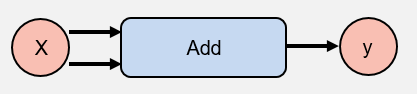

In [2]:
x = Variable(np.array(3.0))
# 동일한 변수(x)를 사용하여 덧셈을 하면? 
y = add(x, x)
print('y :', y.data)

# 역전파
# y = x + x = 2x
# y' = 2가 나와야함
y.backward()
print('x_grad :', x.grad)

y : 6.0
x_grad : 1.0


In [3]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):

              # 기존 역전파 때 전해지는 미분값
              # 같은 변수를 사용하게 되면서 이전 미분값이 저장되어있지만 그대로 덮어 써지기 때문에 누적이 안됨  
              # x.grad = gx

              # 처음으로 역전파 했을 때
                if x.grad is None:
                    x.grad = gx
              # 이후로 다시 역전파 했을 때
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    funcs.append(x.creator)

왜 x.grad += gx 이거말고 x.grad = x.grad + gx 이걸 쓰는가?

In [4]:
import numpy as np
x = np.array(1)
id(x)

140574683537536

In [5]:
# 누적 대입 연산자
# 저장하는 메모리 위치(id) 동일
# 메모리 값만 덮어쓰는 연산
# 인플레이스 연산(in-place operation)
x += x
id(x)

140574683537536

In [6]:
# 저장하는 메모리 위치(id)가 바뀜
# 새로운 ndarray인스턴스가 생성 == 복사
x = x + x
id(x)

140574683055216

In [7]:
# 만약 다시 역전파 했을 때, 누적 대입 연산자(+=)를 사용하게 되면
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):

              # 기존 역전파 때 전해지는 미분값
              # 같은 변수를 사용하게 되면서 이전 미분값이 저장되어있지만 그대로 덮어 써지기 때문에 누적이 안됨  
              # x.grad = gx

              # 처음으로 역전파 했을 때
                if x.grad is None:
                    x.grad = gx
              # 이후로 다시 역전파 했을 때, 누적 대입 연산자를 사용
                else:
                    x.grad += gx # x.grad += x.grad

                if x.creator is not None:
                    funcs.append(x.creator)

x = Variable(np.array(3.0)) 
y = add(x, x)
y.backward()

# y.grad가 1이어야 하는데 2로 되어있음
print('y_grad :', y.grad)
print('x_grad :', x.grad)

y_grad : 2.0
x_grad : 2.0


In [8]:
# 같은 ndarray를 참조하게 되서 이전의 y.grad까지 영향을 받게됨
print('y_grad id :', id(y.grad))
print('x_grad id :', id(x.grad))

y_grad id : 140574683540736
x_grad id : 140574683540736


In [9]:
# 동작 확인
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):

              # 기존 역전파 때 전해지는 미분값
              # 같은 변수를 사용하게 되면서 이전 미분값이 저장되어있지만 그대로 덮어 써지기 때문에 누적이 안됨  
              # x.grad = gx

              # 처음으로 역전파 했을 때
                if x.grad is None:
                    x.grad = gx
              # 이후로 다시 역전파 했을 때
                else:
                    x.grad = x.grad + gx # 그래서 x.grad += x.grad를 쓰지 않고 저걸 씀

                if x.creator is not None:
                    funcs.append(x.creator)

x = Variable(np.array(3.0)) 
# y = x + x = 2x
y = add(x, x)
y.backward()

print('y_grad :', y.grad)
print('x_grad :', x.grad)

y_grad : 1.0
x_grad : 2.0


In [10]:
x = Variable(np.array(3.0)) 
# y = (x + x) + x = 3x 를 하더라도 맞게 나옴 
y = add(add(x, x), x)
y.backward()

print('x_grad :', x.grad)

x_grad : 3.0


In [11]:
# 같은 변수로 다른계산을 할 경우
x = Variable(np.array(3.0)) 

# 첫번째 계산
# y = x + x = 2x
y = add(x, x)
y.backward()
print('1 x_grad :', x.grad)

# 두번째 계산(같은 x, 다른 계산)
# y = (x + x) + x = 3x
y = add(add(x, x), x)
y.backward()
print('2 x_grad :', x.grad)

# 같은 변수를 재사용 할 경우 첫번째 계산에서의 미분값이 남아 있어서 두번째 계산에 영향이 감
# 미분값을 초기화 할 필요가 있음

1 x_grad : 2.0
2 x_grad : 5.0


In [12]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    # 미분값 초기화
    def cleargrad(self):
        self.grad = None

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):

              # 기존 역전파 때 전해지는 미분값
              # 같은 변수를 사용하게 되면서 이전 미분값이 저장되어있지만 그대로 덮어 써지기 때문에 누적이 안됨  
              # x.grad = gx

              # 처음으로 역전파 했을 때
                if x.grad is None:
                    x.grad = gx
              # 이후로 다시 역전파 했을 때
                else:
                    x.grad = x.grad + gx # x.grad += x.grad

                if x.creator is not None:
                    funcs.append(x.creator)

x = Variable(np.array(3.0)) 

# 첫번째 계산
# y = x + x = 2x
y = add(x, x)
y.backward()
print('1 x_grad :', x.grad)

# 미분값 초기화
x.cleargrad()

# 두번째 계산(같은 x, 다른 계산)
# y = (x + x) + x = 3x
y = add(add(x, x), x)
y.backward()
print('2 x_grad :', x.grad)

1 x_grad : 2.0
2 x_grad : 3.0


DeZero의 cleargrad 메서드는 28단계에서 로젠브룩 함수(Rosenbrock function)를 최적화할 때 사용된다.  
* 최적화 문제 : 함수의 최솟값과 최대값을 찾는 문제   

## step15
복잡한 계산 그래프(이론 편)

- 앞의 계산에선 일직선 그래프만 다뤘음
- 그럼 복잡하게 연결된 그래프와 만나게 되면?


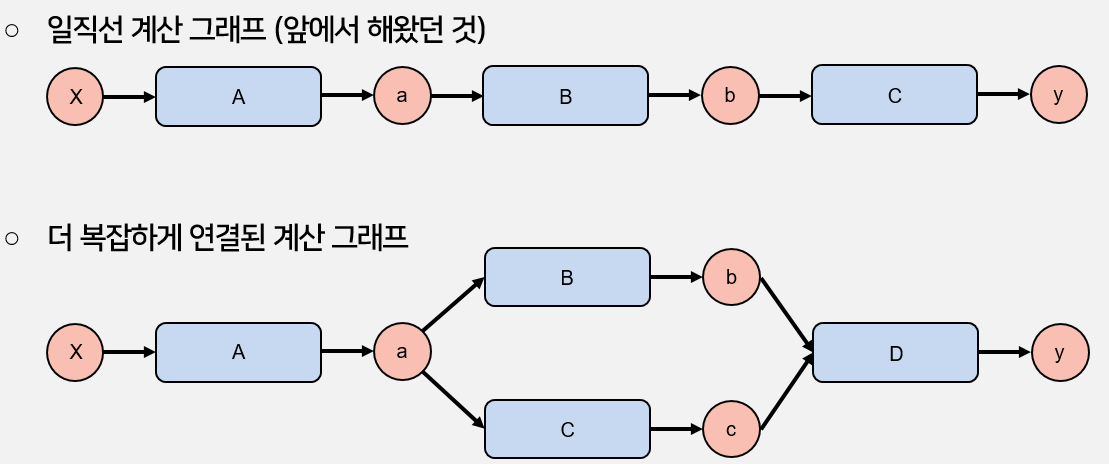

 현재의 역전파 순서
```
class Variable:
        funcs = [self.creator]
        while funcs:
        # 처리해야할 함수 리스트 끝에 있는걸 꺼내오고 있음
            f = funcs.pop()
            ...
                if x.creator is not None:
                # 다음으로 처리해야할 함수 후보를 리스트 끝에 추가하고 있음
                    funcs.append(x.creator)
```
이대로 갈 경우 : D -> C -> A -> B -> A
- 문제점 1 : C 다음으로 B를 수행하지 않음
- 문제점 2 : A의 역전파가 두번 됨

순전파(일반적인 계산)에서 어떤 함수가 어떤 변수를 만들어 내는 과정
- 창조자-피조물 관계
- 부모-자식 관계  

이 관계를 이용하면 원하는 순서대로 처리할 수 있지 않을까?


처리해야할 함수의 우선순위(세대)를 정함
- 우선순위(세대)가 높은 것 부터 처리하면 C 다음 A와 B가 있을때 B를 먼저 처리할 수 있게됨

## step16
복잡한 계산 그래프(구현 편)

1. 세대 추가
2. 세대 순으로 꺼내기


In [13]:
# 1. 세대 추가 : 세대를 나타내줄 변수 추가
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None
        # 세대를 나타내줄 변수 추가
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        # 세대를 기록
        self.generation = func.generation + 1 # 자식 세대 = 부모 세대 + 1

    def cleargrad(self):
        self.grad = None

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    funcs.append(x.creator)

In [14]:
# 1. 세대 추가 : 함수의 세대는 이전의 입력변수의 세대를 이어받음
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        # 함수의 세대는 이전의 입력변수의 세대를 이어받음
        # 입력변수가 2개 이상이라면 가장 큰 세대를 이어받기 위해 max 메서드를 씀
        self.generation = max([x.generation for x in inputs])
        
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx


def square(x):
    return Square()(x)


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    return Add()(x0, x1)

다음으로 세대순으로 꺼내보는 방법을 간단히 설명하자면,


In [15]:
# 임의로 함수의 세대를 지정
generations = [2, 0, 1, 4, 2]
funcs = []

for g in generations:
  f = Function() # Function 클래스의 generation를 빌려서 사용
  f.generation = g
  funcs.append(f) # 처리해야할 함수 리스트에 넣어둠

[f.generation for f in funcs]

[2, 0, 1, 4, 2]

In [16]:
# sort 메서드를 이용하여 오름차순으로 정렬
# x.generation을 key로 사용해 정렬할것
funcs.sort(key=lambda x: x.generation)
[f.generation for f in funcs]

[0, 1, 2, 2, 4]

In [17]:
# 가장 큰 값(세대)을 꺼냄 == 리스트의 마지막을 꺼내옴
for idx in reversed(range(len(funcs))):
  f = funcs.pop()
  print(f'{idx} generation : {f.generation}')

4 generation : 4
3 generation : 2
2 generation : 2
1 generation : 1
0 generation : 0


In [36]:
# 2. 세대순으로 꺼내기
class Variable:
  def __init__(self, data):
      if data is not None:
          if not isinstance(data, np.ndarray):
              raise TypeError('{} is not supported'.format(type(data)))

      self.data = data
      self.grad = None
      self.creator = None
      self.generation = 0

  def set_creator(self, func):
      self.creator = func
      self.generation = func.generation + 1 # 자식 세대 = 부모 세대 + 1

  def cleargrad(self):
      self.grad = None

  def backward(self):
      if self.grad is None:
          self.grad = np.ones_like(self.data)

      funcs = []
      # 집합을 사용하는 이유는 add_func 함수 안에서 funcs를 추가할 때 중복하지 않게 할려고
      seen_set = set()

      # backward 함수의 중첩함수로 정의
      # 함수 리스트를 세대순으로 정렬하는 역할
      def add_func(f):
          if f not in seen_set:
              funcs.append(f)
              seen_set.add(f)
              funcs.sort(key=lambda x: x.generation)

      add_func(self.creator)
      count = 0

      while funcs:
        print(f'{count} : {funcs}')
        f = funcs.pop()
        gys = [output.grad for output in f.outputs]
        gxs = f.backward(*gys)
        count += 1
        if not isinstance(gxs, tuple):
            gxs = (gxs,)

        for x, gx in zip(f.inputs, gxs):
            if x.grad is None:
                x.grad = gx
            else:
                x.grad = x.grad + gx

            if x.creator is not None:
              print('x.creator is not None :', x.creator)
              add_func(x.creator) # funcs.append(x.creator)로 다음세대를 funcs에 바로 추가하던 것을 add_func 함수를 통해서 하도록 함

중첩 함수 (Nested Function): 함수 안에 정의된 함수
- 자신이 속한 원래 함수 안에서만 역할을 하며, 원래 함수의 밖에서는 인식이 안된다.

출처: https://rfriend.tistory.com/368 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

여기서의 add_func(중첩 함수)는,  
- 감싸는 메서드(backward 메서드) 안에서만 이용된다.
- 감싸는 메서드(backward 메서드)에 적용된 변수(funcs와 seen_set)를 사용해야 한다.

In [37]:
# 동작 확인
x = Variable(np.array(2.0))
a = square(x)  
y = add(square(a), square(a))
y.backward()
print('')
print('y_data :', y.data)
print('x_grad :', x.grad)

0 : [<__main__.Add object at 0x7fda17fa31d0>]
x.creator is not None : <__main__.Square object at 0x7fda17fa3090>
x.creator is not None : <__main__.Square object at 0x7fda17fa30d0>
1 : [<__main__.Square object at 0x7fda17fa3090>, <__main__.Square object at 0x7fda17fa30d0>]
x.creator is not None : <__main__.Square object at 0x7fda17f95590>
2 : [<__main__.Square object at 0x7fda17f95590>, <__main__.Square object at 0x7fda17fa3090>]
x.creator is not None : <__main__.Square object at 0x7fda17f95590>
3 : [<__main__.Square object at 0x7fda17f95590>]

y_data : 32.0
x_grad : 64.0
